# AI Generated Classical Piano Music

Team Members: Firas Georges, Moshe Amar, Alexander Akyian, Juan Martinez, Jose Hernandez

## Project Overview
**Objective:** To generate original classical piano music using a Recurrent Neural Network (RNN).

**Problem:** Music composition is a complex creative task that involves long-term structure and harmony. We are attempting to see if an AI can learn these patterns from MIDI data.

**Methodology:**
1. **Data:** MIDI files processed into sequential notes and chords.
2. **Model:** A Stacked Long Short-Term Memory (LSTM) network.
3. **Evaluation:** Various metrics (Accuracy, F1 Score, etc.) and qualitative listening tests.

## Setup and Data Upload

In [ ]:
import os
from google.colab import files

# Install music21 for MIDI processing and tqdm for progress bars
!pip install -q music21 tqdm

# Upload the Kaggle dataset zip file
print("Please upload your Kaggle zip file...")
uploaded = files.upload()

# Extract the uploaded zip file to ./midi_data directory
filename = next(iter(uploaded))
print(f"Unzipping {filename}...")
!unzip -q "{filename}" -d ./midi_data

print("Data is ready!")

Please upload your Kaggle zip file...


Saving archive.zip to archive.zip
Unzipping archive.zip...
Data is ready!


## Data Preprocessing

In [ ]:
import glob
import numpy as np
from music21 import converter, instrument, note, chord
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tqdm import tqdm

# HYPERPARAMETERS
SEQUENCE_LENGTH = 100  # Number of notes used to predict the next note

# Find all MIDI files recursively in the extracted directory
all_files = glob.glob("./midi_data/**/*.mid", recursive=True)
midi_files = all_files

print(f"Found {len(midi_files)} MIDI files. Processing all of them...")

# List to store all parsed notes and chords
notes = []

# Parse each MIDI file and extract notes/chords
for file in tqdm(midi_files, desc="Parsing MIDI files"):
    try:
        midi = converter.parse(file)
        notes_to_parse = None

        # Try to extract notes from the first instrument part
        try:
            s2 = instrument.partitionByInstrument(midi)
            if s2 is not None and len(s2.parts) > 0:
                notes_to_parse = s2.parts[0].recurse()
            else:
                notes_to_parse = midi.flat.notes
        except Exception:
            # If partitioning fails, get all notes from flattened structure
            notes_to_parse = midi.flat.notes

        # Extract pitch information from notes and chords
        for element in notes_to_parse:
            if isinstance(element, note.Note):
                # Store single notes as pitch string (e.g., "C4", "D#5")
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                # Store chords as dot-separated pitch class integers (e.g., "0.4.7")
                notes.append('.'.join(str(n) for n in element.normalOrder))
    except Exception:
        # Skip files that cannot be parsed (corrupted or incompatible format)
        continue

# Create mappings between notes and integers for model input/output
pitchnames = sorted(set(notes))
n_vocab = len(pitchnames)  # Total number of unique notes/chords
note_to_int = {note: number for number, note in enumerate(pitchnames)}
int_to_note = {number: note for number, note in enumerate(pitchnames)}

print(f"\nTotal Notes Parsed: {len(notes)}")
print(f"Unique Notes (Vocabulary): {n_vocab}")

# Create input sequences and corresponding output labels
# Each input is SEQUENCE_LENGTH notes, output is the next note
network_input = []
network_output = []

for i in range(0, len(notes) - SEQUENCE_LENGTH):
    sequence_in = notes[i:i + SEQUENCE_LENGTH]
    sequence_out = notes[i + SEQUENCE_LENGTH]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])

n_patterns = len(network_input)

# Reshape input for LSTM: (samples, timesteps, features)
# Normalize by dividing by vocabulary size to scale values between 0-1
X = np.reshape(network_input, (n_patterns, SEQUENCE_LENGTH, 1))
X = X / float(n_vocab)

# One-hot encode the output labels for categorical cross-entropy loss
y = to_categorical(network_output, num_classes=n_vocab)

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Training Sequences: {X_train.shape[0]}")
print(f"Testing Sequences: {X_test.shape[0]}")

Found 292 MIDI files. Processing all of them...


Parsing MIDI files:   0%|          | 0/292 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/music21/midi/translate.py:922: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=0, data=b'Pr\xe4ludium und Fuge in D-Dur, BWV 850'>; getting generic Instrument
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/music21/midi/translate.py:922: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=8, data=b'Copyright 1997 by Bernd Kr\xfcger.'>; getting generic Instrument
  warnings.warn(
Parsing MIDI files:   0%|          | 1/292 [00:02<09:58,  2.06s/it]/usr/local/lib/python3.12/dist-packages/music21/midi/translate.py:922: TranslateWarning: Unable to determine instrument from <music21.midi.MidiEvent SEQUENCE_TRACK_NAME, track=7, data=b'Copyright 2004 by Bernd Kr\xfcger.'>; getting generic Instrument
  warnings.warn(
Parsing MIDI files:   1%|          | 2/292 [00:04<11:52,  2.46s/i


Total Notes Parsed: 11362
Unique Notes (Vocabulary): 222
Training Sequences: 9009
Testing Sequences: 2253


## Model Architecture and Training

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping

# Build a stacked LSTM model for sequence-to-one prediction
model = Sequential([
    # First LSTM layer: 512 units, returns sequences for stacking
    LSTM(512, input_shape=(X.shape[1], X.shape[2]), return_sequences=True),
    Dropout(0.3),  # Dropout to prevent overfitting

    # Second LSTM layer: 512 units, returns sequences
    LSTM(512, return_sequences=True),
    Dropout(0.3),

    # Third LSTM layer: 512 units, returns only final output
    LSTM(512, return_sequences=False),

    # Dense layer for additional learning capacity
    Dense(256, activation='relu'),
    Dropout(0.3),

    # Output layer: predicts probability distribution over all possible notes
    Dense(n_vocab, activation='softmax')
])

# Compile with categorical cross-entropy (multi-class classification)
# RMSprop optimizer works well for recurrent networks
model.compile(
    loss='categorical_crossentropy',
    optimizer='rmsprop',
    metrics=['accuracy']
)

model.summary()

# Callbacks for saving best model and early stopping
checkpoint = ModelCheckpoint(
    "best_model.keras",
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print("Starting Training...")
history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=64,
    callbacks=[checkpoint, early_stop]
)
print("Training Complete.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 512)       │     1,052,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 512)       │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 512)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 512)            │     2,099,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 222)            │        57,054 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,439,454 (20.75 MB)

 Trainable params: 5,439,454 (20.75 MB)

 Non-trainable params: 0 (0.00 B)

Starting Training...
Epoch 1/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.0257 - loss: 4.9595
Epoch 1: val_loss improved from inf to 4.51845, saving model to best_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 18s 88ms/step - accuracy: 0.0257 - loss: 4.9583 - val_accuracy: 0.0515 - val_loss: 4.5185
Epoch 2/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.0409 - loss: 4.5221
Epoch 2: val_loss improved from 4.51845 to 4.48392, saving model to best_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 12s 85ms/step - accuracy: 0.0409 - loss: 4.5220 - val_accuracy: 0.0431 - val_loss: 4.4839
Epoch 3/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.0456 - loss: 4.4392
Epoch 3: val_loss improved from 4.48392 to 4.41211, saving model to best_model.keras
141/141 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.0456 - loss: 4.4392 - val_accuracy: 0.0408 - val_loss: 4.4121
Epoch 4/50
141/141 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.0534 - loss: 4.3935
Epoch 4: val_loss did n

## Evaluation and Visualization

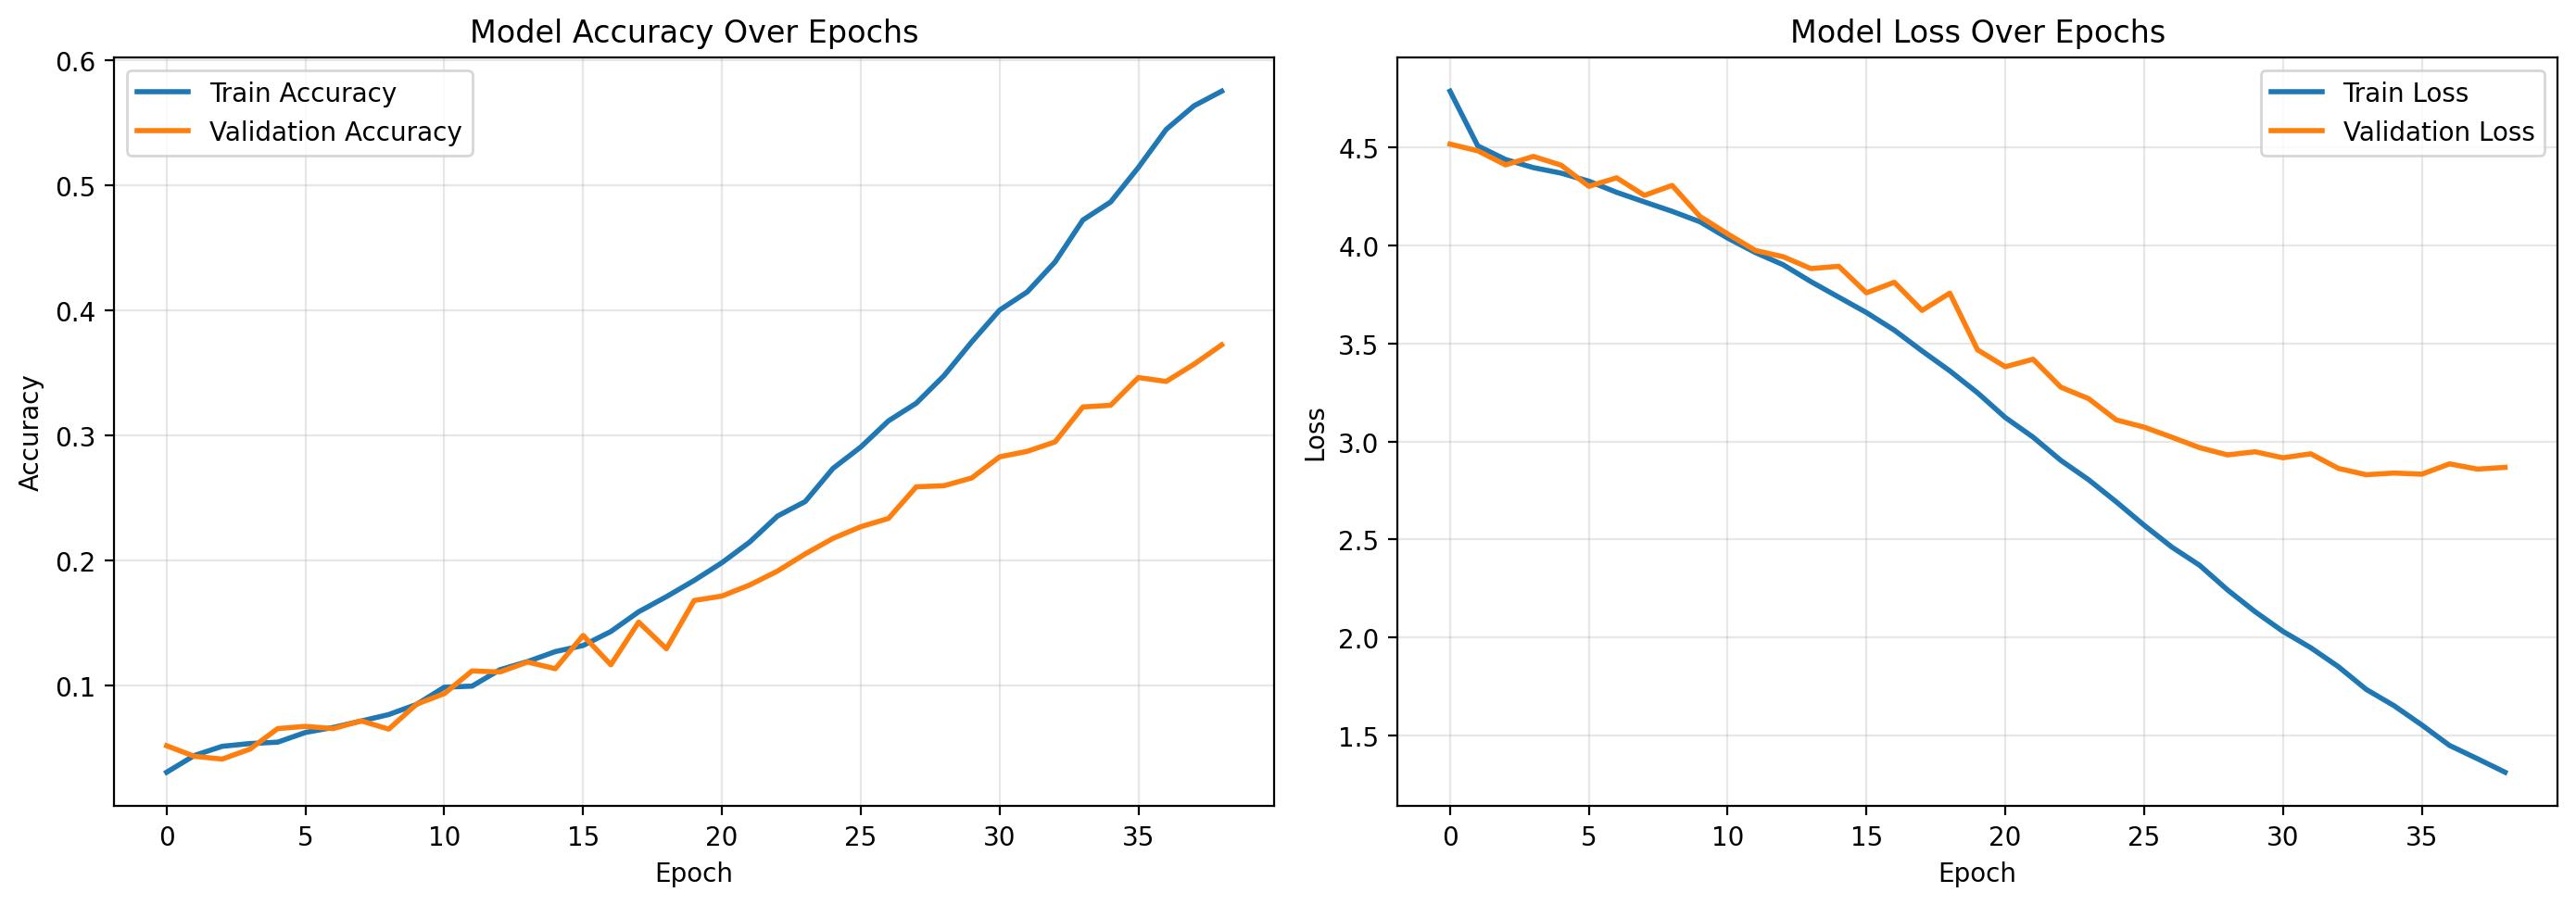

Calculating Metrics on Test Set...

FINAL EVALUATION RESULTS
Accuracy:  0.3227
Precision: 0.3304
Recall:    0.3227
F1 Score:  0.3142


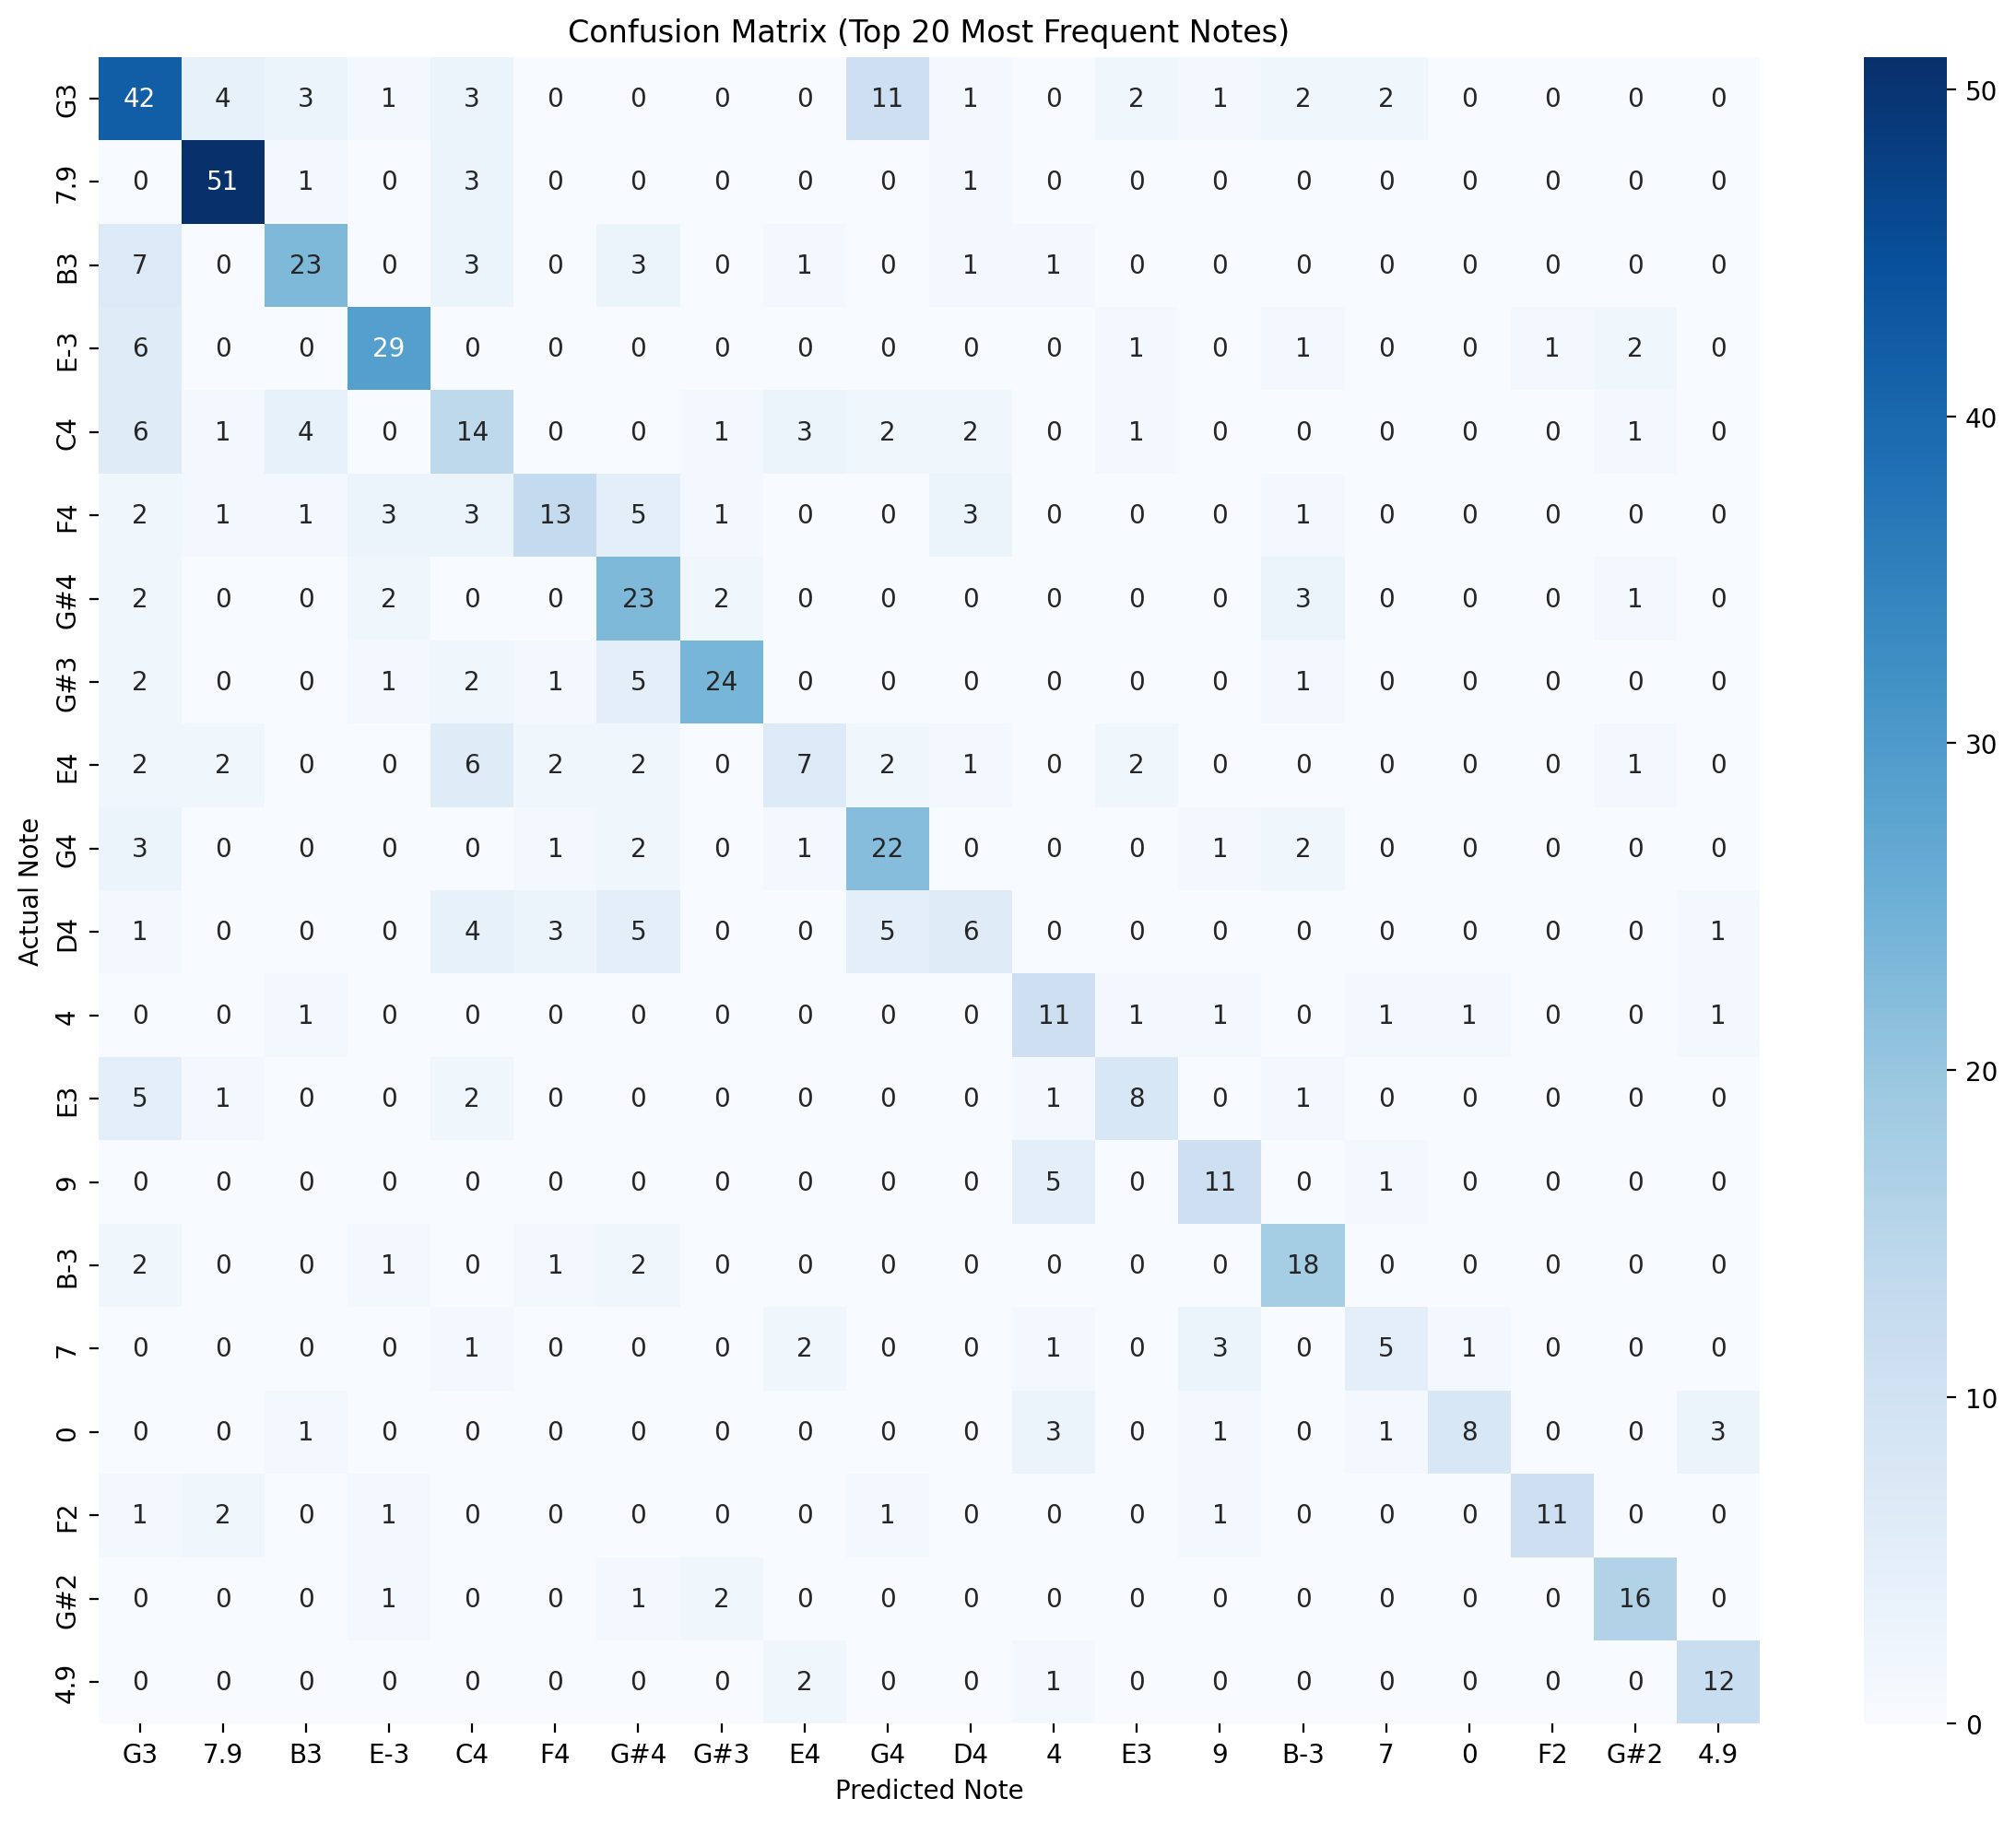

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from collections import Counter

# Plot training history - Accuracy and Loss curves
plt.figure(figsize=(14, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
plt.title('Model Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
plt.title('Model Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_graphs.png', dpi=150)
plt.show()

# Calculate evaluation metrics on test set
print("Calculating Metrics on Test Set...")
y_pred_probs = model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Calculate standard classification metrics
acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("\n" + "=" * 40)
print("FINAL EVALUATION RESULTS")
print("=" * 40)
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1 Score:  {f1:.4f}")
print("=" * 40)

# Generate confusion matrix for top 20 most frequent notes
# (Full matrix would be too large to visualize with hundreds of unique notes)
counts = Counter(y_true)
top_classes = [x[0] for x in counts.most_common(20)]
top_labels = [int_to_note[x] for x in top_classes]

# Filter predictions to only include top 20 classes
mask = np.isin(y_true, top_classes)
y_true_filtered = y_true[mask]
y_pred_filtered = y_pred[mask]

cm = confusion_matrix(y_true_filtered, y_pred_filtered, labels=top_classes)

plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=top_labels, yticklabels=top_labels
)
plt.title('Confusion Matrix (Top 20 Most Frequent Notes)')
plt.xlabel('Predicted Note')
plt.ylabel('Actual Note')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

## Music Generation

In [ ]:
from music21 import stream
import random

def sample_with_temperature(probabilities, temperature=1.0):
    """
    Helps add 'creativity' to the music.
    High temp (>1.0) = More random/creative
    Low temp (<0.5) = More strict/repetitive
    """
    probabilities = np.asarray(probabilities).astype('float64')
    probabilities = np.log(probabilities + 1e-7) / temperature
    exp_preds = np.exp(probabilities)
    probabilities = exp_preds / np.sum(exp_preds)
    probabilities = np.random.multinomial(1, probabilities, 1)
    return np.argmax(probabilities)


def generate_music(model, network_input, n_vocab, int_to_note, num_notes=300, temperature=1.0):
    """
    Generate a sequence of notes using the trained model.

    Args:
        model: Trained Keras model
        network_input: List of training sequences (used to pick random seed)
        n_vocab: Vocabulary size for normalization
        int_to_note: Dictionary mapping integers to note strings
        num_notes: Number of notes to generate
        temperature: Controls randomness (0.5=conservative, 1.0=balanced, 1.5=creative)

    Returns:
        List of generated note strings
    """
    # Pick a random sequence from training data as the seed
    start = np.random.randint(0, len(network_input) - 1)
    pattern = list(network_input[start])  # Make a copy to avoid modifying original
    prediction_output = []

    print(f"Generating {num_notes} notes with temperature {temperature}...")
    for _ in tqdm(range(num_notes), desc="Generating"):
        # Prepare input: reshape and normalize
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        prediction_input = prediction_input / float(n_vocab)

        # Predict next note probabilities
        prediction = model.predict(prediction_input, verbose=0)[0]
        index = sample_with_temperature(prediction, temperature)
        result = int_to_note[index]
        prediction_output.append(result)

        # Slide the window: append new note, remove oldest note
        pattern.append(index)
        pattern = pattern[1:]

    return prediction_output


def create_midi(prediction_output, filename):
    """
    Convert a list of note strings to a MIDI file.

    Args:
        prediction_output: List of note strings (pitches or chord representations)
        filename: Output MIDI file path

      Features:
        - Pattern-based rhythmic variation
    """
    offset = 0  # Current position in the piece (in quarter notes)
    output_notes = []

    # Common rhythmic patterns (in quarter note units)
    patterns = [
        [0.5, 0.5, 0.5, 0.5],           # Steady eighths
        [1.0, 0.5, 0.5],                # Quarter, eighth, eighth
        [0.5, 0.5, 1.0],                # Eighth, eighth, quarter
        [0.75, 0.25, 0.5, 0.5],         # Dotted eighth, sixteenth, eighths
        [1.0, 1.0],                     # Two quarters
    ]

    # offsets:
    # offset += 0.25  # Sixteenth notes (very fast)
    # offset += 0.5   # Eighth notes (default)
    # offset += 1.0   # Quarter notes (slower, more dramatic)
    # offset += 1.5   # Dotted quarter notes (even slower)

    current_pattern = random.choice(patterns)
    pattern_index = 0

    for pattern in prediction_output:
        # Check if pattern is a chord (contains dots or is purely numeric)
        if ('.' in pattern) or pattern.isdigit():
            # Parse chord: split by dots and create Note objects from pitch classes
            notes_in_chord = pattern.split('.')
            chord_notes = []
            for current_note in notes_in_chord:
                # Add 60 to shift to middle octave (MIDI 60 = Middle C)
                new_note = note.Note(int(current_note) + 60)
                new_note.storedInstrument = instrument.Piano()
                chord_notes.append(new_note)
            new_chord = chord.Chord(chord_notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        else:
            # Parse single note from pitch string
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # Get duration from current pattern
        offset += current_pattern[pattern_index]
        pattern_index += 1

        # When pattern ends, pick a new one
        if pattern_index >= len(current_pattern):
            current_pattern = random.choice(patterns)
            pattern_index = 0

    # Create stream and write to MIDI file
    midi_stream = stream.Stream(output_notes)
    midi_stream.write('midi', fp=filename)
    print(f"Saved: {filename}")


# Generate new music using the trained model
# Temperature: 0.5=safe, 0.8=balanced, 1.0=creative, 1.2=experimental
generated_notes = generate_music(model, network_input, n_vocab, int_to_note, num_notes=200, temperature=0.8)
create_midi(generated_notes, 'ai_generated_composition.mid')

Generating 200 notes with temperature 0.8...


Generating: 100%|██████████| 200/200 [00:15<00:00, 12.59it/s]

Saved: ai_generated_composition.mid


## Download Results

In [ ]:
# Download generated files
files.download('ai_generated_composition.mid')
# files.download('training_graphs.png')
# files.download('confusion_matrix.png')

print("All files downloaded successfully!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

All files downloaded successfully!
